<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/content%2Fw2d5_tutorial_revs/tutorials/W2D5_ReinforcementLearning/student/W2D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Neuromatch Academy: Week 2, Day 5, Tutorial 2
# Learning to Act: Multi-Armed Bandits

__Content creators:__ Marcelo Mattar and Eric DeWitt with help from Byron Galbraith

__Content reviewers:__ Matt Krause and Michael Waskom


---

# Tutorial Objectives
  
In this tutorial you will use 'bandits' to understand the fundementals of how a policy interacts with the learning algorithm in reinforcement learning.
    
* You will understand the fundemental tradeoff between exploration and exploitation in a policy.
* You will understand how the learning rate interacts with exploration to find the best available action.

---
# Setup

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [5]:
#@title Helper functions
np.set_printoptions(precision=3)

def plot_choices(q, epsilon, choice_fn, n_steps=1000, rng_seed=1):
  np.random.seed(rng_seed)
  counts = np.zeros_like(q)
  for t in range(n_steps):
    action = choice_fn(q, epsilon)
    counts[action] += 1

  fig, ax = plt.subplots()
  ax.bar(range(len(q)), counts/n_steps)
  ax.set(ylabel='% chosen', xlabel='action', ylim=(0,1), xticks=range(len(q)))


def plot_multi_armed_bandit_results(results):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 4))       
  ax1.plot(results['rewards'])
  ax1.set(title=f"Total Reward: {np.sum(results['rewards']):.2f}",
          xlabel='step', ylabel='reward')
  ax2.plot(results['qs'])
  ax2.set(xlabel='step', ylabel='value')
  ax2.legend(range(len(results['mu'])))
  ax3.plot(results['mu'], label='latent')
  ax3.plot(results['qs'][-1], label='learned')
  ax3.set(xlabel='action', ylabel='value')
  ax3.legend()


def plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
  
  ax1.plot(np.mean(trial_rewards, axis=1).T)
  ax1.set(title=f'Average Reward ({fixed})', xlabel='step', ylabel='reward')
  ax1.legend(labels)

  ax2.plot(np.mean(trial_optimal, axis=1).T)
  ax2.set(title=f'Performance ({fixed})', xlabel='step', ylabel='% optimal')
  ax2.legend(labels)

---
# Section 1: Multi-Armed Bandits

Video available at https://youtu.be/kdiXr1zsfo0


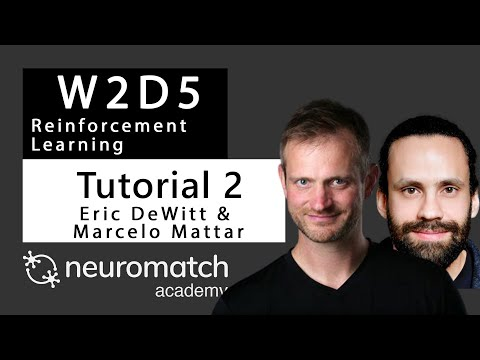

In [ ]:
#@title Video 1: Multi-Armed Bandits
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="kdiXr1zsfo0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Consider the following learning problem. You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a reward signal in the form of a numerical value, where the larger value is the better. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

This is the original form of the k-armed bandit problem. This name derives from the colloquial name for a slot machine, the "one-armed bandit", because it has the one lever to pull, and it is often rigged to take more money than it pays out over time. The multi-armed bandit extension is to imagine, for instance, that you are faced with multiple slot machines that you can play, but only one at a time. Which machine should you play, i.e. which arm should you pull, which action should you take, at any given time to maximize your total payout.

<img alt="MultiArmedBandit" width="625" height="269" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial2_MultiarmedBandit.png?raw=true">


While there are many different levels of sophistication and assumptions in how the rewards are determined, for simplicity sake we will assume that each action results in a reward drawn from a fixed Gaussian distribution with unknown mean and unit variance. This problem setting is referred to as the *environment*, and goal is to find the arm with the highest mean value.

We will solve this *optimization problem* with an *agent*, in this case an algorithm that takes in rewards and returns actions.

---
# Section 2: Choosing an Action
   
The first thing our agent needs to be able to do is choose which arm to pull. The strategy for choosing actions based on our expectations is called a *policy* (often denoted $\pi$). We could have a random policy -- just pick an arm at random each time -- though this doesn't seem likely to be capable of optimizing our reward. We want some intentionality, and to do that we need a way of describing our beliefs about the arms' reward potential. We do this with an action-value function

\begin{align}
q(a) = \mathbb{E} [r_{t} | a_{t} = a]
\end{align}

where the value $q$ for taking action $a \in A$ at time $t$ is equal to the expected value of the reward $r_t$ given that we took action $a$ at that time. In practice, this is often represented as an array of values, where each action's value is a different element in the array.

Great, now that we have a way to describe our beliefs about the values each action should return, let's come up with a policy.

An obvious choice would be to take the action with the highest expected value. This is referred to as the *greedy* policy

\begin{align}
a_{t} = \text{argmax}_{a} \; q_{t} (a)
\end{align}

where our choice action is the one that maximizes the current value function.

So far so good, but it can't be this easy. And, in fact, the greedy policy does have a fatal flaw: it easily gets trapped in local maxima. It never explores to see what it hasn't seen before if one option is already better than the others. This leads us to a fundamental challenge in coming up with effective polices.

## Section 2.1: The Exploitation-Exploration Dilemma

If we never try anything new, if we always stick to the safe bet, we don't know what we are missing. Sometimes we aren't missing much of anything, and regret not sticking with our preferred choice, yet other times we stumble upon something new that was way better than we thought.

This is the exploitation-exploration dilemma: do you go with you best choice now, or risk the less certain option with the hope of finding something better. Too much exploration, however, means you may end up with a sub-optimal reward once it's time to stop.

In order to avoid getting stuck in local minima while also maximizing reward, effective policies need some way to balance between these two aims.

A simple extension to our greedy policy is to add some randomness. For instance, a coin flip -- heads we take the best choice now, tails we pick one at random. This is referred to as the $\epsilon$-greedy policy:

\begin{align}
P (a_{t} = a) = 
        \begin{cases}
        1 - \epsilon    & \quad \text{if } a_{t} = \text{argmax}_{a} \; q_{t} (a) \\
        \epsilon/N        & \quad \text{else} 
        \end{cases} 
\end{align}

which is to say that the probability of selecting the greedy choice is equal to 1 - $\epsilon$ for $\epsilon \in [0,1]$ otherwise we select the action at random.

Despite its relative simplicity, the epsilon-greedy policy is quite effective, which leads to its general popularity.

### Exercise 1: Implement Epsilon-Greedy

In this exercise you will implement the epsilon-greedy algorithm for deciding which action to take from a set of possible actions given their value function and a probability $\epsilon$ of simply chosing one at random. 

TIP: You may find [`np.random.random`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html), [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), and [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful here.

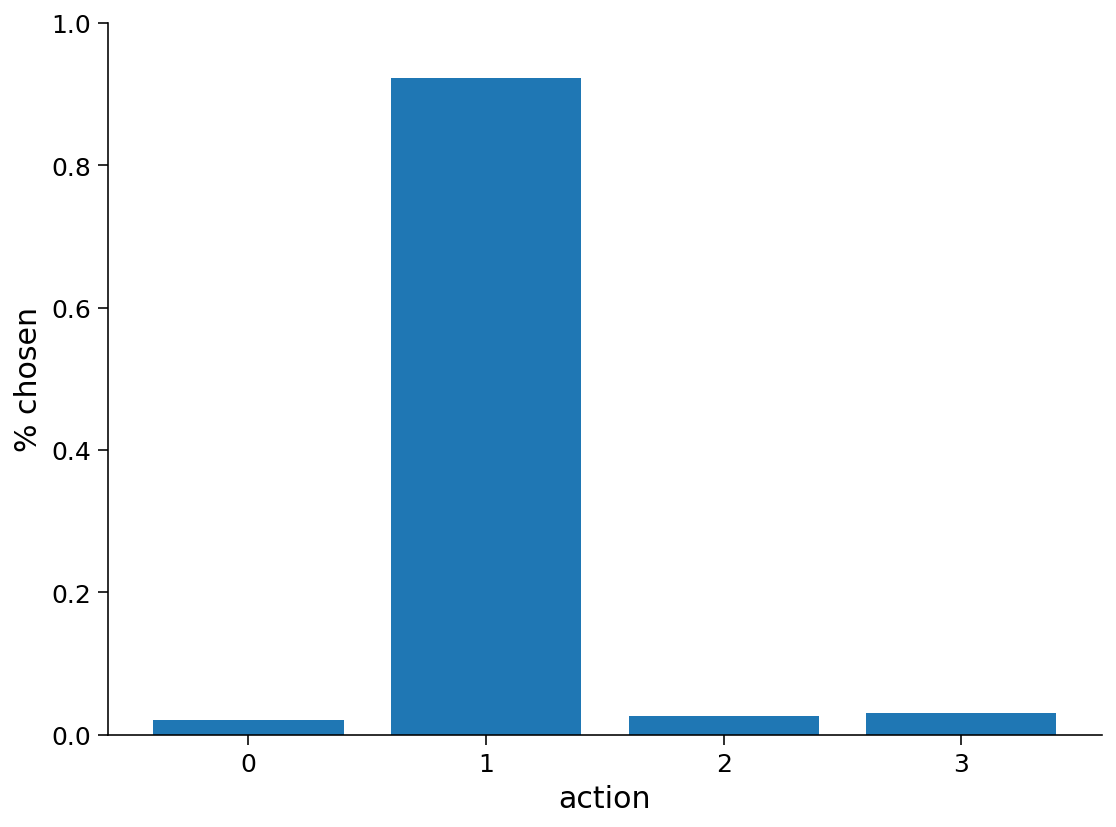

In [7]:
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.
    
  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly
  
  Returns:
    int: the chosen action
  """
  #####################################################################
  ## TODO for students: implement the epsilon greedy decision algorithm
  # Fill out function and remove
  #raise NotImplementedError("Student excercise: implement the epsilon greedy decision algorithm")
  #####################################################################
  # write a boolean expression that determines if we should take the best action
  be_greedy = np.random.random() > epsilon
  if be_greedy:
    # write an expression for selecting the best action from the action values
    action = np.argmax(q)
  else:
    # write an expression for selecting a random action
    action = np.random.choice(len(q))
    
  return action


# Uncomment once the epsilon_greedy function is complete
q = [-2, 5, 0, 1]
epsilon = 0.1
plot_choices(q, epsilon, epsilon_greedy)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial2_Solution_82effe96.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial2_Solution_82effe96_0.png>



This is what we should expect, that the action with the largest value (action 1) is selected about (1-$\epsilon$) of the time, or 90% for $\epsilon = 0.1$, and the remaining 10% is split evenly amongst the other options. Use the demo below to explore how changing $\epsilon$ affects the distribution of selected actions.

### Interactive Demo: Changing Epsilon

Epsilon is our one parameter for balancing exploitation and exploration.  Given a set of values $q = [-2, 5, 0, 1]$, use the widget below to see how changing $\epsilon$ influences our selection of the max value 5 (action = 1) vs the others. 

At the extremes of its range (0 and 1), the $\epsilon$-greedy policy reproduces two other policies. What are they?

In [8]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0))
def explore_epilson_values(epsilon=0.1):
  q = [-2, 5, 0, 1]
  plot_choices(q, epsilon, epsilon_greedy, rng_seed=None)

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=1.0), Output()), _dom_classes=('widget…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial2_Solution_ac609d98.py)



---
# Section 3: Learning from Rewards

Now that we have a policy for deciding what to do, how do we learn from our actions?

One way to do this is just keep a record of every result we ever got and use the averages for each action. If we have a potentially very long running episode, the computational cost of keeping all these values and recomputing the mean over and over again isn't ideal. Instead we can use a streaming mean calculation, which looks like this:

\begin{align}
q_{t+1}(a) \leftarrow q_{t}(a) + \frac{1}{n_t} (r_{t} - q_{t}(a))
\end{align}

where our action-value function $q_t(a)$ is the mean of the rewards seen so far, $n_t$ is the number of actions taken at time $t$, and $r_t$ is the reward just received for taking action $a$.

This still requires us to remember how many actions we've taken, so let's generalize this a bit further and replace the action total with a general parameter $\alpha$, which we will call the learning rate

\begin{align}
q_{t+1}(a) \leftarrow q_{t}(a) + \alpha (r_{t} - q_{t}(a)).
\end{align}

## Exercise 2: Updating Action Values

In this exercise you will implement the action-value update rule above. The function will take in the action-value function represented as an array `q`, the action taken, the reward received, and the learning rate, `alpha`. The function will return the updated value for the selection action.

In [11]:
def update_action_value(q, action, reward, alpha):
  """ Compute the updated action value given the learning rate and observed
  reward.

  Args:
    q (ndarray): an array of action values
    action (int): the action taken
    reward (float): the reward received for taking the action
    alpha (float): the learning rate
  
  Returns:
    float: the updated value for the selected action
  """
  #####################################################
  ## TODO for students: compute the action value update
  # Fill out function and remove
  #raise NotImplementedError("Student excercise: compute the action value update")
  #####################################################
  # write an expression for the updated action value
  value = q[action] +alpha*(reward-q[action])
  return value


# Uncomment once the update_action_value function is complete
q = [-2, 5, 0, 1]
action = 2
print(f"Original q({action}) value = {q[action]}")
q[action] = update_action_value(q, 2, 10, 0.01)
print(f"Updated q({action}) value = {q[action]}")

Original q(2) value = 0
Updated q(2) value = 0.1


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial2_Solution_81e49f1e.py)



---
# Section 4: Solving Multi-Armed Bandits

Now that we have both a policy and a learning rule, we can combine these to solve our original multi-armed bandit task. Recall that we have some number of arms that give rewards drawn from Gaussian distributions with unknown mean and unit variance, and our goal is to find the arm with the highest mean.

First, let's see how we will simulate this environment by reading through the annotated code below.

In [12]:
def multi_armed_bandit(n_arms, epsilon, alpha, n_steps):
  """ A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
  action, rewards are randomly sampled from normal distribution, with a mean
  associated with that arm and unit variance.
  
  Args:
    n_arms (int): number of arms or actions
    epsilon (float): probability of selecting an action randomly
    alpha (float): the learning rate
    n_steps (int): number of steps to evaluate
  
  Returns:
    dict: a dictionary containing the action values, actions, and rewards from
    the evaluation along with the true arm parameters mu and the optimality of
    the chosen actions.
  """
  # Gaussian bandit parameters  
  mu = np.random.normal(size=n_arms)

  # evaluation and reporting state
  q = np.zeros(n_arms)
  qs = np.zeros((n_steps, n_arms))
  rewards = np.zeros(n_steps)
  actions = np.zeros(n_steps)
  optimal = np.zeros(n_steps)

  # run the bandit
  for t in range(n_steps):
    # choose an action
    action = epsilon_greedy(q, epsilon)
    actions[t] = action
    
    # copmute rewards for all actions
    all_rewards = np.random.normal(mu)
    # observe the reward for the chosen action
    reward = all_rewards[action]    
    rewards[t] = reward
    # was it the best possible choice?
    optimal_action = np.argmax(all_rewards)
    optimal[t] = action == optimal_action

    # update the action value
    q[action] = update_action_value(q, action, reward, alpha)
    qs[t] = q

  results = {
      'qs': qs,
      'actions': actions,
      'rewards': rewards,
      'mu': mu,
      'optimal': optimal
  }
  
  return results

We can use our multi-armed bandit method to evaluate how our epsilon-greedy policy and learning rule perform at solving the task. First we will set our environment to have 10 arms and our agent parameters to $\epsilon=0.1$ and $\alpha=0.01$. In order to get a good sense of the agent's performance, we will run the episode for 1000 steps.

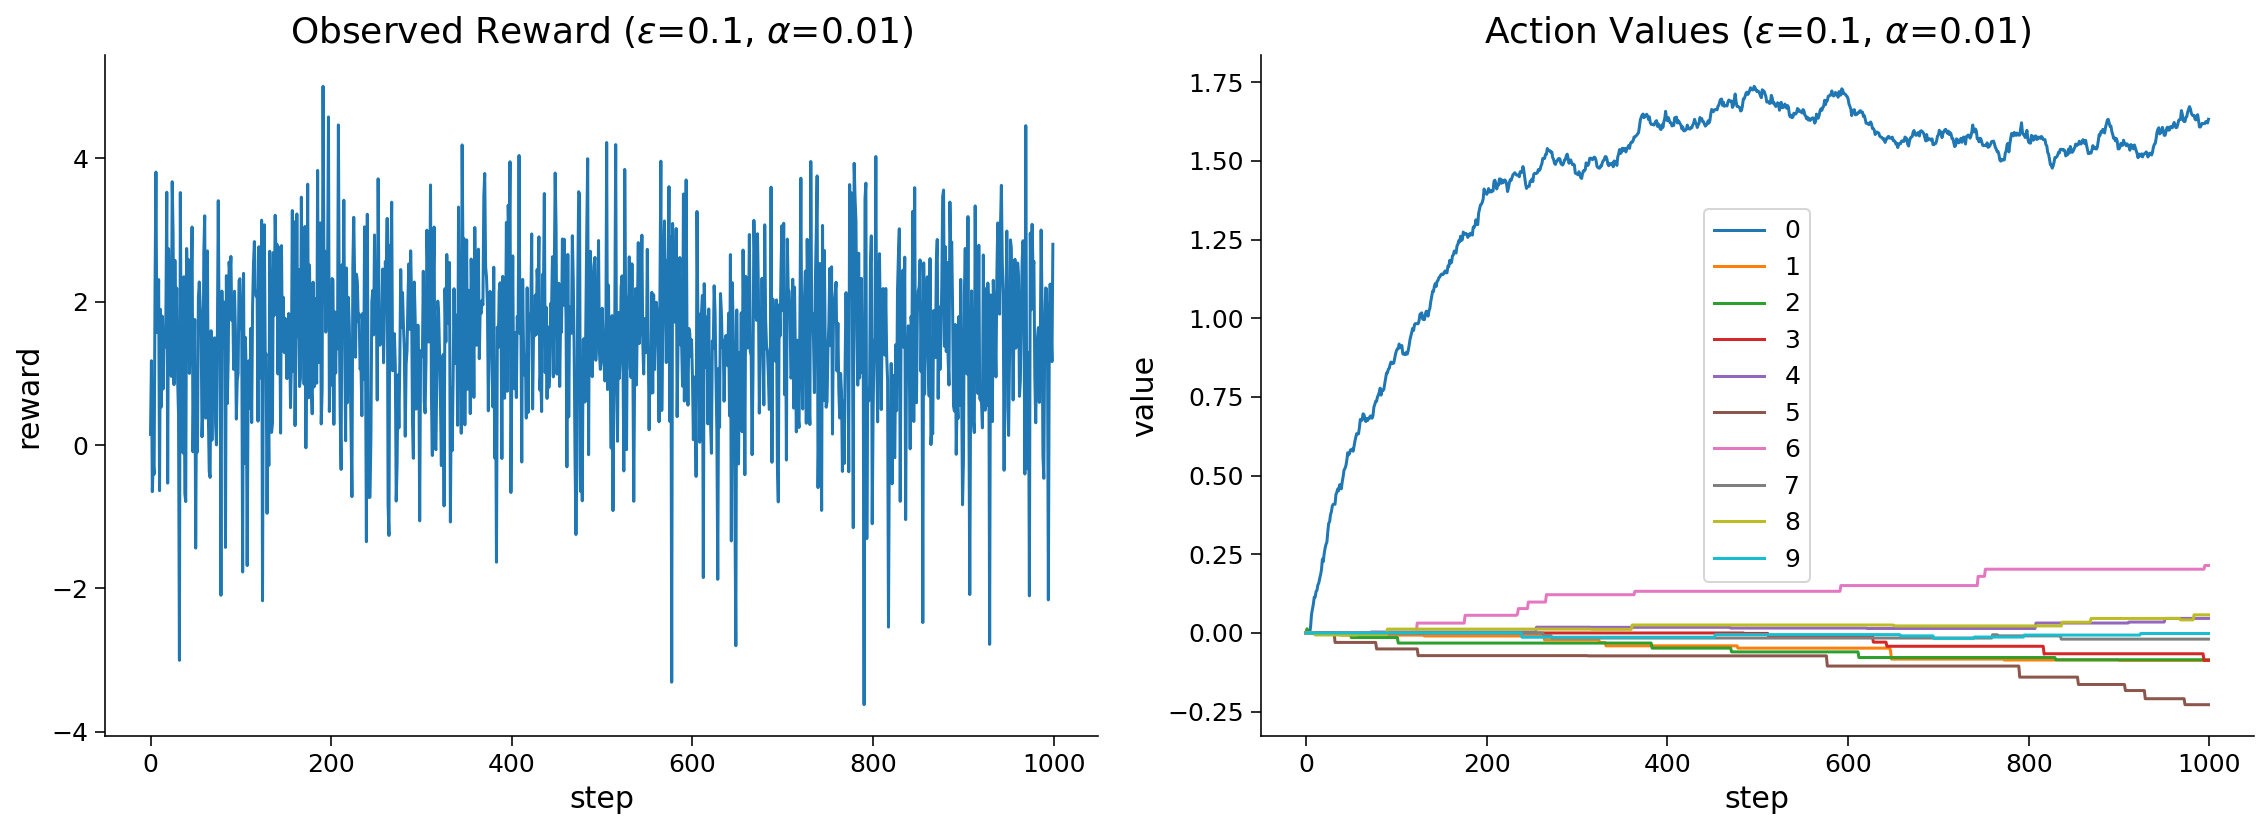

In [14]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

n_arms = 10
epsilon = 0.1
alpha = 0.01
n_steps = 1000

results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))     
ax1.plot(results['rewards'])
ax1.set(title=f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})', 
        xlabel='step', ylabel='reward')
ax2.plot(results['qs'])
ax2.set(title=f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})', 
        xlabel='step', ylabel='value')
ax2.legend(range(n_arms));

Alright, we got some rewards that are kind of all over the place, but the agent seemed to settle in on the first arm as the preferred choice of action relatively quickly. Let's see how well we did at recovering the true means of the Gaussian random variables behind the arms.

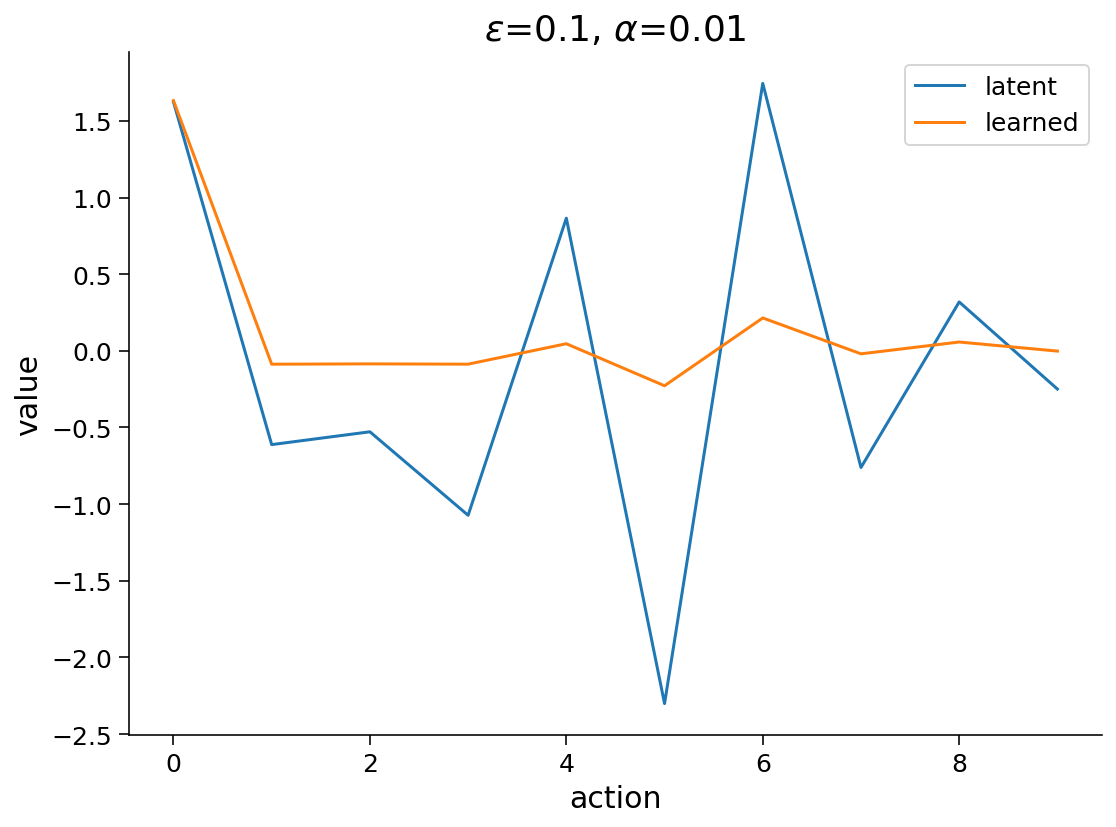

In [ ]:
fig, ax = plt.subplots()
ax.plot(results['mu'], label='latent')
ax.plot(results['qs'][-1], label='learned')
ax.set(title=f'$\epsilon$={epsilon}, $\\alpha$={alpha}',
       xlabel='action', ylabel='value')
ax.legend();

Well, we seem to have found a very good estimate for action 0, but most of the others are not great. In fact, we can see the effect of the local maxima trap at work -- the greedy part of our algorithm locked onto action 0, which is actually the 2nd best choice to action 6. Since these are the means of Gaussian random variables, we can see that the overlap between the two would be quite high, so even if we did explore action 6, we may draw a sample that is still lower than our estimate for action 0.

However, this was just one choice of parameters. Perhaps there is a better combination?



## Interactive Demo: Changing Epsilon and Alpha

Use the widget below to explore how varying the values of $\epsilon$ (exploitation-exploration tradeoff), $\alpha$ (learning rate), and even the number of actions $k$, changes the behavior of our agent.

In [15]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact_manual(n_arms=widgets.IntSlider(10, min=2, max=15),
                         epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0),
                         alpha=widgets.FloatLogSlider(0.01, min=-3, max=0))
def explore_bandit_parameters(k=10, epsilon=0.1, alpha=0.001):
  results = multi_armed_bandit(k, epsilon, alpha, 1000)
  plot_multi_armed_bandit_results(results)

interactive(children=(IntSlider(value=10, description='k', max=30, min=-10), FloatSlider(value=0.1, descriptio…

While we can see how changing the epsilon and alpha values impact the agent's behavior, this doesn't give as a great sense of which combination is optimal. Due to the stochastic nature of both our rewards and our policy, a single trial run isn't sufficient to give us this information. Let's run mulitple trials and compare the average performance.

First we will look at differet values for $\epsilon \in [0.0, 0.1, 0.2]$ to a fixed $\alpha=0.1$. We will run 200 trials as a nice balance between speed and accuracy.

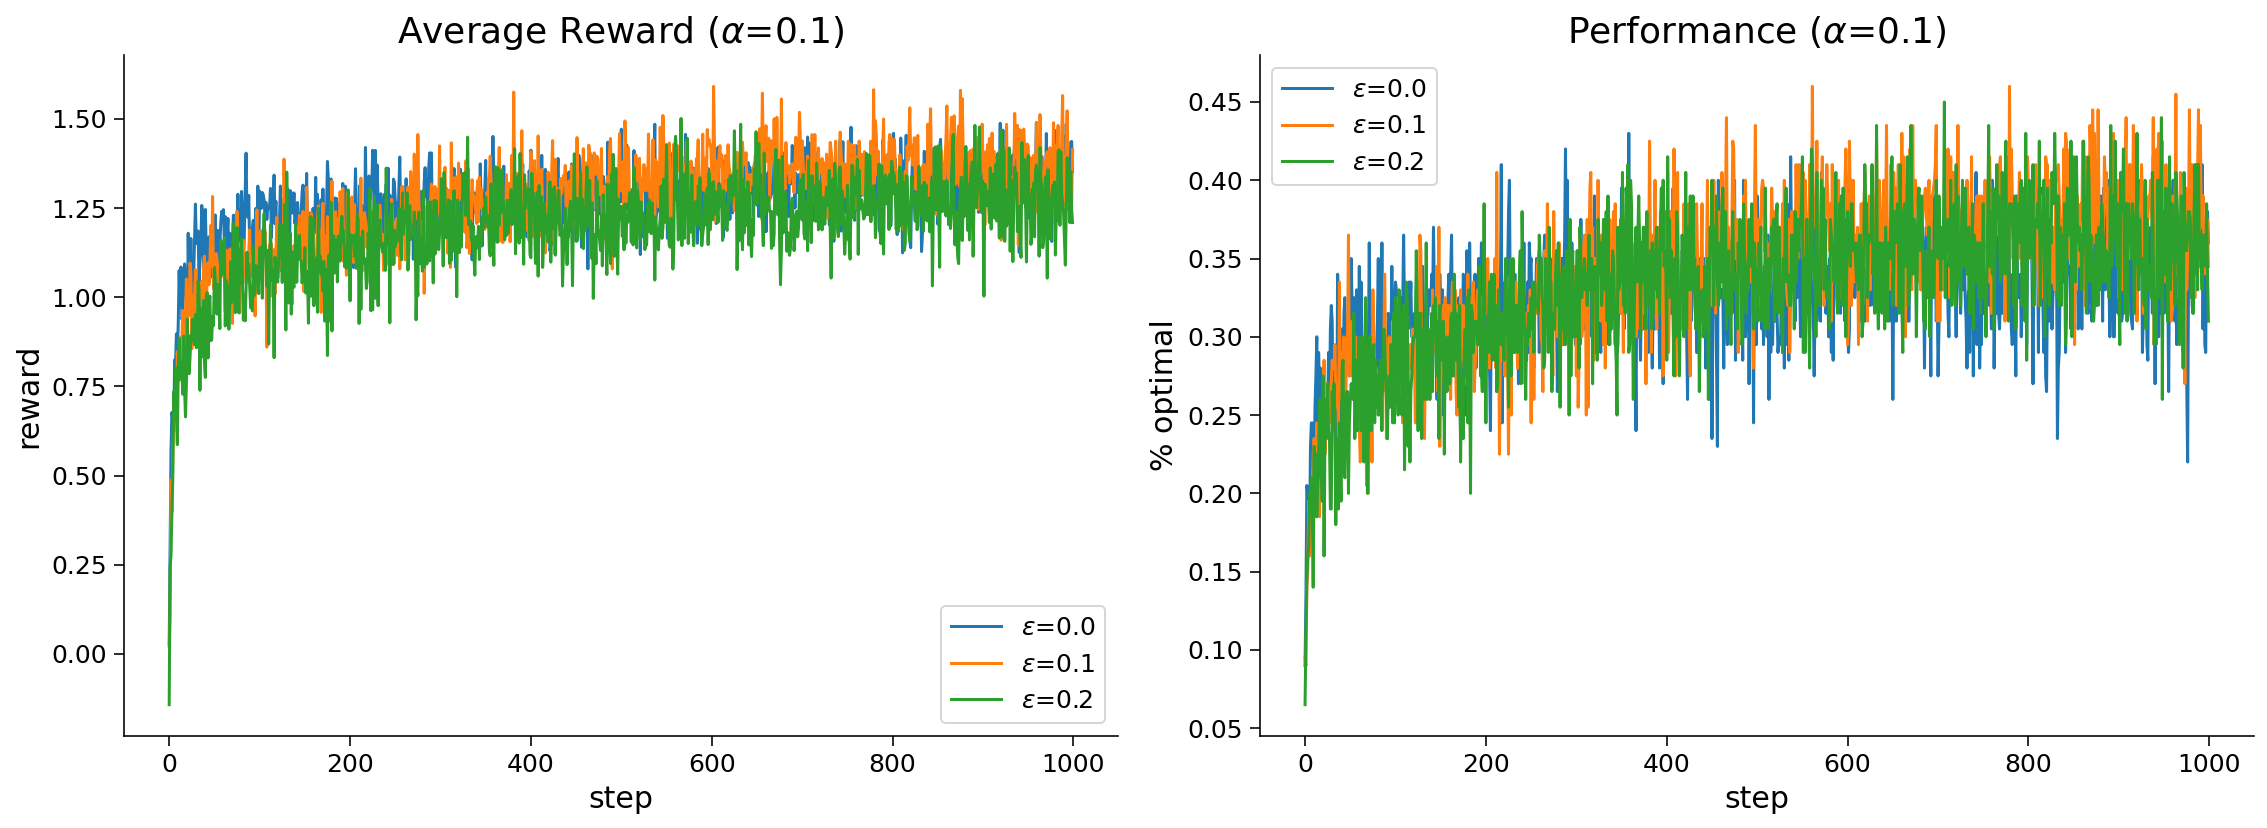

In [16]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilons = [0.0, 0.1, 0.2]
alpha = 0.1
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, epsilon in enumerate(epsilons):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\epsilon$={e}' for e in epsilons]
fixed = f'$\\alpha$={alpha}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

On the left we have plotted the average reward over time, and we see that while $\epsilon=0$ (the greedy policy) does well initially, $\epsilon=0.1$ starts to do slightly better in the long run, while $\epsilon=0.2$ does the worst. Looking on the right, we see the percentage of times the optimal action (the best possible choice at time $t$) was taken, and here again we see a similar pattern of $\epsilon=0.1$ starting out a bit slower but eventually having a slight edge in the longer run.

We can also do the same for the learning rates. We will evaluate $\alpha \in [0.01, 0.1, 1.0]$ to a fixed $\epsilon=0.1$.

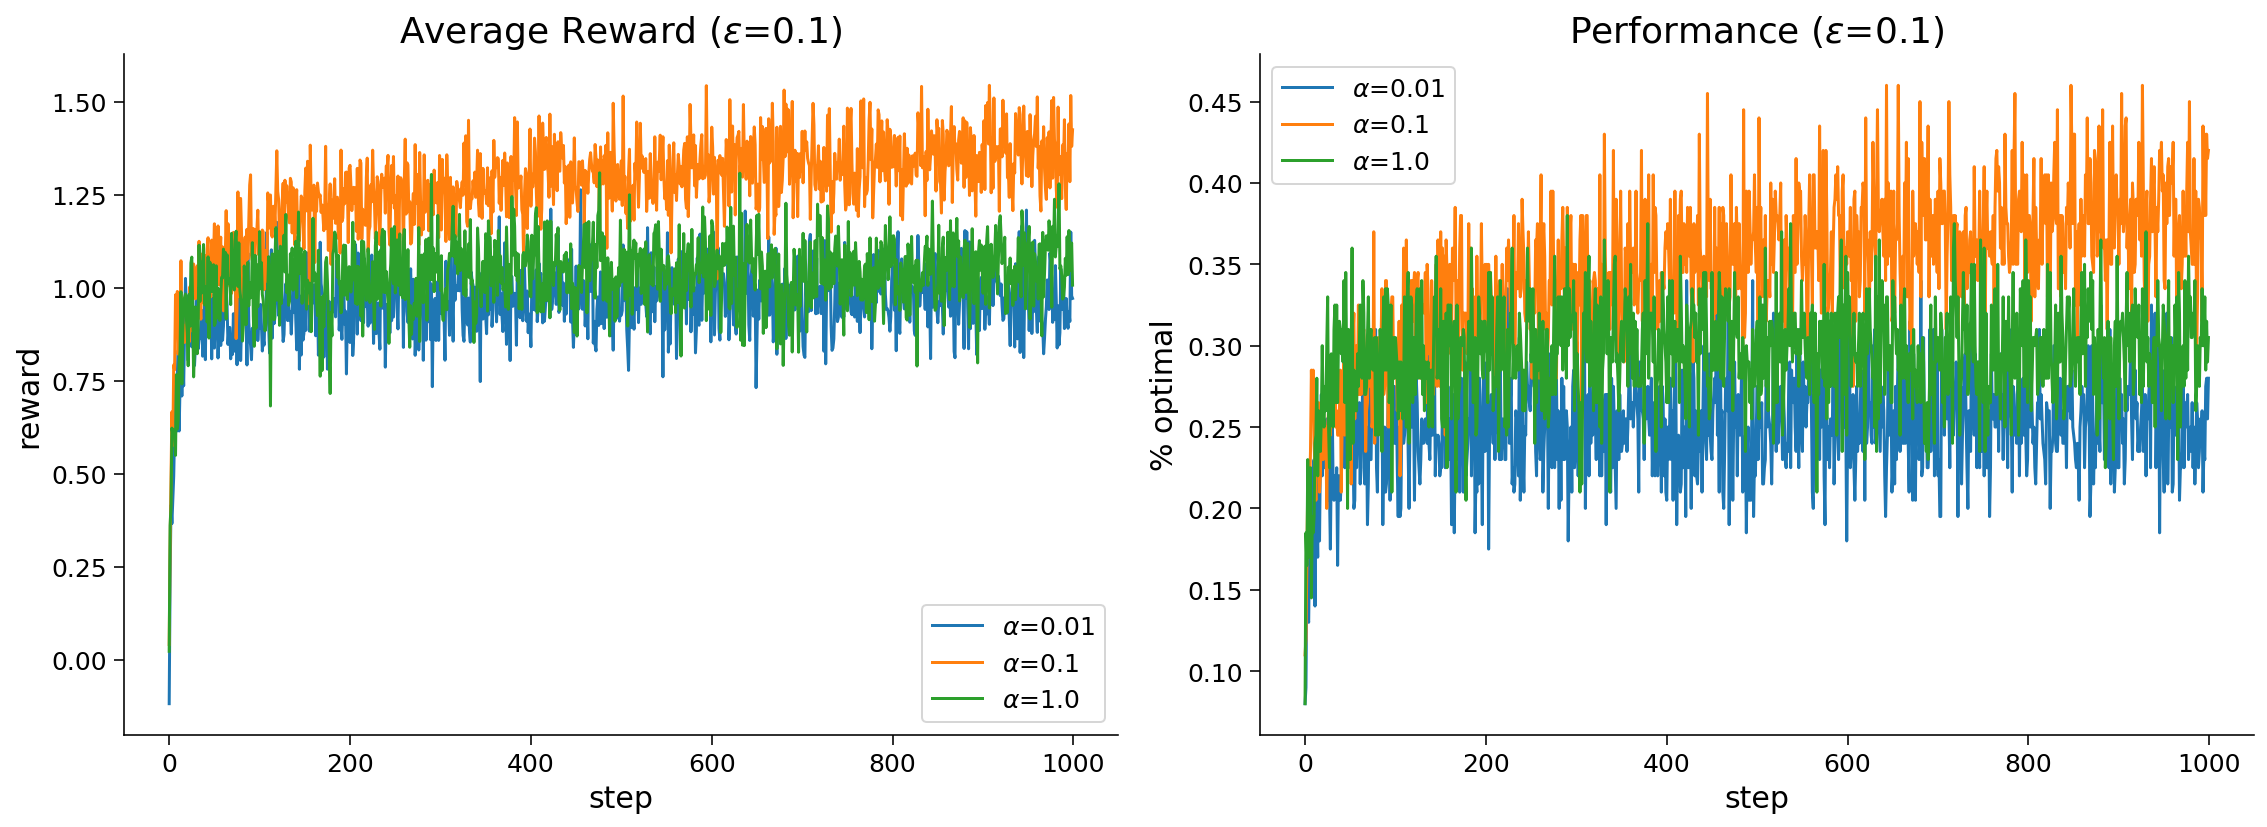

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilon = 0.1
alphas = [0.01, 0.1, 1.0]
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, alpha in enumerate(alphas):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\\alpha$={a}' for a in alphas]
fixed = f'$\epsilon$={epsilon}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

Again we see a balance between an effective learning rate. $\alpha=0.01$ is too weak to quickly incorporate good values, while $\alpha=1$ is too strong likely resulting in high variance in values due to the Gaussian nature of the rewards.

---
# Summary

In this tutorial you implemented both the epsilon-greedy descision algorithm and a learning rule for solving a multi-armed bandit scenario. You saw how balancing exploitation and exploration in action selection is crtical in finding optimal solutions. You also saw how choosing an appropriate learning rate determines how well an agent can generalize the information they receive from rewards.
